In [6]:
import getpass
import os
from dotenv import load_dotenv

In [7]:
load_dotenv()

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

In [8]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")
router_llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [9]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [10]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./db",  
)

In [11]:
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.document_loaders import csv_loader
from langchain_community.document_loaders import TextLoader
pdf_docs_loaders = []
text_docs_loaders = []

data_directory = "./assets"
file_list = os.listdir(data_directory)
all_docs = []
for file in file_list:
    if str(file).endswith('.pdf'):
        file_path = os.path.join(data_directory, file)
        pdf_loader = PyMuPDFLoader(file_path)
        pdf_docs_loaders.append(pdf_loader.load())
    elif str(file).endswith(".txt"):
        file_path = os.path.join(data_directory, file)
        text_loader = TextLoader(file_path)
        text_docs_loaders.append(text_loader.load())

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
docs = []
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 200)
for doc_loader in pdf_docs_loaders:
    for doc in doc_loader:
        docs.append(doc)
for doc_loaders in text_docs_loaders:
    for doc in doc_loaders:
        docs.append(doc)
docs = text_splitter.split_documents(documents = docs)

In [13]:
len(docs)

353

In [13]:
indices = vector_store.add_documents(documents = docs)

In [14]:
from langchain_core.prompts import PromptTemplate
base_model_prompt_template = PromptTemplate.from_template("""
        You are an expert in question answering regarding HDFC Life Smart Protect Plan.
        You are given a query: {query} and its relevant information for answering.
        relevant information :{similar_docs}
        Answer the query with only relevant information.
        Donot hallicunate, donot provide information beyond the context.
        Make sure the response doesn't contain personal information such as names, contact and numbers.
        Make sure not use any offensive words.
""")


router_prompt_template = PromptTemplate.from_template("""
Given the user's question, decide whether it is more appropriate to perform a RAG search
or a web search. Respond with 'RAG' if the question can be answered from the provided
documents (HDFC Life Smart Protect Plan), or 'WEB' if it requires external, up-to-date
information or information beyond the scope of the HDFC Life Smart Protect Plan.

Question: {question}
Decision:
""")

In [25]:
from langgraph.graph import START, StateGraph, END
from typing_extensions import List, TypedDict
from langchain_core.documents import Document


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    decision: str

def router(state: State):
    router_prompt = router_prompt_template.invoke({'question': state['question']})
    decision = router_llm.invoke(router_prompt).content
    return {'decision': decision}

def retrieve_documents(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def web_search(state: State):
    # web_results = web_search_tool.invoke({"query": state["question"]})
    return {"context": [Document(page_content='Web Search')], "answer": 'web_results'} 

def generate_rag_response(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = base_model_prompt_template.invoke({"query": state["question"], "similar_docs": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State)
graph_builder.add_node("router", router)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("web_search", web_search)
graph_builder.add_node("generate_rag_response", generate_rag_response)



graph_builder.set_entry_point("router")

graph_builder.add_conditional_edges(
    "router",
    lambda state: state['decision'],
    {
        "RAG": "retrieve_documents",
        "WEB": "web_search",
    }, 
)
graph_builder.add_edge("retrieve_documents", "generate_rag_response")
graph_builder.add_edge("retrieve_documents", END)
graph_builder.add_edge("web_search", END)

graph = graph_builder.compile()

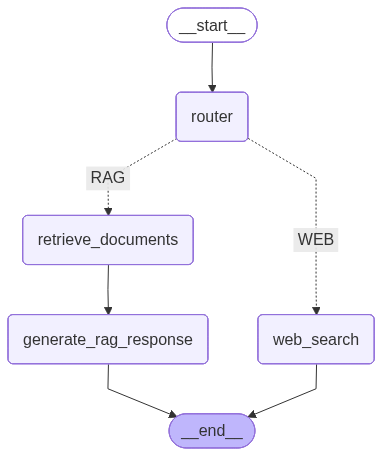

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
response = graph.invoke({"question": "What is HDFC's stock price today?"})
print(response["answer"])

web_results


In [27]:
response = graph.invoke({"question": "Provide Premium allocation charges in table format"})
print(response["answer"])

Here is the table format for the Premium Allocation Charges of HDFC Life Smart Protect Plan:

| Policy Year      | AP < 2.5 Lacs (%) | AP >= 2.5 Lacs (%) |
|------------------|--------------------|---------------------|
| 1                | 12%                | 11%                 |
| 2                | 6%                 | 5%                  |
| 3                | 4%                 | 4%                  |
| 4                | 3%                 | 3%                  |
| 5 year onward    | 0%                 | 0%                  |

- A Premium Allocation Charge of 2% is applicable on top-up Premiums.
- The Premium Allocation Charge is capped at 12.5% of the annualized Premium in any year and is guaranteed for the entire duration of the Policy Term.


In [31]:
for message, metadata in graph.stream(
    {"question": "Provide Premium allocation charges in table format"}, stream_mode="messages"
):
    print(message.content, end="")

RAGHere is the information regarding the Premium Allocation Charges for the HDFC Life Smart Protect Plan in a table format:

| Policy Year          | Annualized Premium < ₹2.5 lacs | Annualized Premium ≥ ₹2.5 lacs |
|---------------------|---------------------------------|---------------------------------|
| 1                   | 12%                             | 11%                             |
| 2                   | 6%                              | 5%                              |
| 3                   | 4%                              | 4%                              |
| 4                   | 3%                              | 3%                              |
| 5 years onwards     | 0%                              | 0%                              |

- A Premium Allocation Charge of 2% is applicable on top-up Premiums.
- The Premium Allocation Charges are guaranteed for the entire duration of the Policy Term and are levied at the time of receipt of Premium.